# PatchCoreViT Analysis

## Preparations

In [1]:
! pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=174e9f1c380e6834a9b0643b638e7d2283efeb548b1ec82849d2374d13126ec1
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [2]:
import importlib

import os
import cv2
import wget
import json
import torch
import shutil
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import Thesis_dev
import Utility

from Utility import get_results, print_results, save_json
from Thesis_dev import MVTecDataset, PatchCoreViT, VanillaPatchCore, PatchCoreSWin

class_links = {
    "bottle": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937370-1629951468/bottle.tar.xz",
    "cable": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937413-1629951498/cable.tar.xz"
}
'''
    "capsule": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz",
    "carpet": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz",
    "grid": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937487-1629951814/grid.tar.xz",
    "hazelnut": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz",
    "leather": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937607-1629951964/leather.tar.xz",
    "metal_nut": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz",
    "pill": "https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz",
    "screw": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938130-1629953152/screw.tar.xz",
    "tile": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938133-1629953189/tile.tar.xz",
    "toothbrush": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938134-1629953256/toothbrush.tar.xz",
    "transistor": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz",
    "wood": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938383-1629953354/wood.tar.xz",
    "zipper": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938385-1629953449/zipper.tar.xz"
}
'''

'\n    "capsule": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937454-1629951595/capsule.tar.xz",\n    "carpet": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz",\n    "grid": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937487-1629951814/grid.tar.xz",\n    "hazelnut": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937545-1629951845/hazelnut.tar.xz",\n    "leather": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937607-1629951964/leather.tar.xz",\n    "metal_nut": "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937637-1629952063/metal_nut.tar.xz",\n    "pill": "https://www.mydrive.ch/shares/43421/11a215a5749fcfb75e331ddd5f8e43ee/download/420938129-1629953099/pill.tar.xz",\n    "screw": "https://www.mydrive.ch/shares/38536/3830184030e49fe747476694

In [3]:
# Download duration 6m 5s
for class_name in class_links:
  os.mkdir(class_name)
  file_path = wget.download(class_links[class_name], class_name)
  if os.path.exists(file_path):
    # Extract the file if it's a tar.xz file
    if file_path.endswith('.tar.xz'):
      shutil.unpack_archive(file_path, extract_dir=class_name)
      os.remove(file_path)
      print(f"File {class_name} downloaded and extracted successfully.")
    else:
      print(f"Failed to download the file {class_name}.")

File bottle downloaded and extracted successfully.
File cable downloaded and extracted successfully.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# remove
# shutil.rmtree("bottle")

# Models examples usage

In [30]:
importlib.reload(Utility)
importlib.reload(Thesis_dev)

from Utility import get_results, print_results, save_json, create_gif
from Thesis_dev import MVTecDataset, PatchCoreViT, VanillaPatchCore, PatchCoreSWin

## Vanilla

In [40]:
# Config
model_params_cnn = {
  "layers" : ["layer2", "layer3"],
  "backbone" : "timm/wide_resnet50_2.tv_in1k",
  "f_coreset" : 1
}

# Training CNN
pc = VanillaPatchCore(**model_params_cnn)
pc.fit(["/content/bottle/bottle/train/good"])

[INFO][__init__] Model PatchCore loaded on device: cuda


100%|██████████| 209/209 [00:10<00:00, 20.12it/s]


In [34]:
# Predict one sample
filepath = "/content/bottle/bottle/test/broken_large/000.png"
show_config_cnn = {
    "input_idx": 147,
    "input_path": filepath,
    "model": pc,
    "save": False,
    "alpha": 0.7
}

sample_cnn = pc.get_sample(filepath)

euclidean_distance = pc.cdist
cosine_similarity_distance = pc.sdist

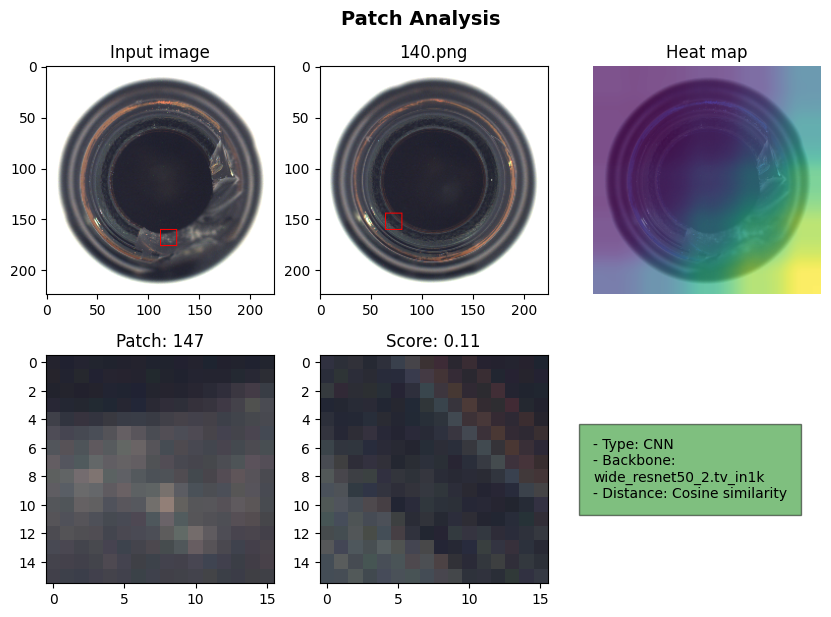

In [46]:
# Euclidean Distance
score, segm_map = pc.predict(sample_cnn, euclidean_distance)

Utility.show(**show_config_cnn)

# Will work only with the concatenation of layer3 with layer4
# Utility.create_gif(filepath, pc, euclidean_distance, duration=150)

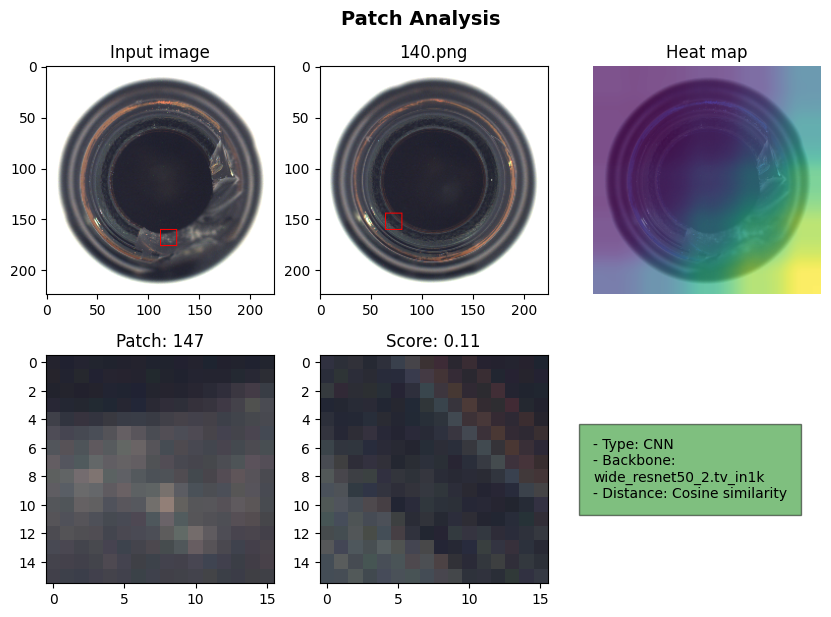

In [44]:
# Cosine Similarity Distance
score, segm_map = pc.predict(sample_cnn, cosine_similarity_distance)

show_config_cnn['distance_label'] = "Cosine similarity"
Utility.show(**show_config_cnn)

# Will work only with the concatenation of layer3 with layer4
# Utility.create_gif(filepath, pc, cosine_similarity_distance, duration=150)

## ViT

In [24]:
# Config
model_params_vit = {
  "layers" : [4],
  "backbone" : "google/vit-base-patch16-224-in21k",
  "f_coreset" : 1
}

# Training ViT
pcViT = PatchCoreViT(**model_params_vit)
pcViT.fit(["/content/bottle/bottle/train/good"])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


[INFO][__init__] Model PatchCore loaded on device: cuda


100%|██████████| 209/209 [00:11<00:00, 18.22it/s]


In [56]:
# Predict one sample
filepath = "/content/bottle/bottle/test/broken_large/000.png"
show_config_vit = {
    "input_idx": 147,
    "input_path": filepath,
    "model": pcViT,
    "save": False,
    "alpha": 0.7
}

sample_vit = pcViT.get_sample(filepath)

euclidean_distance = pcViT.cdist
cosine_similarity_distance = pcViT.sdist

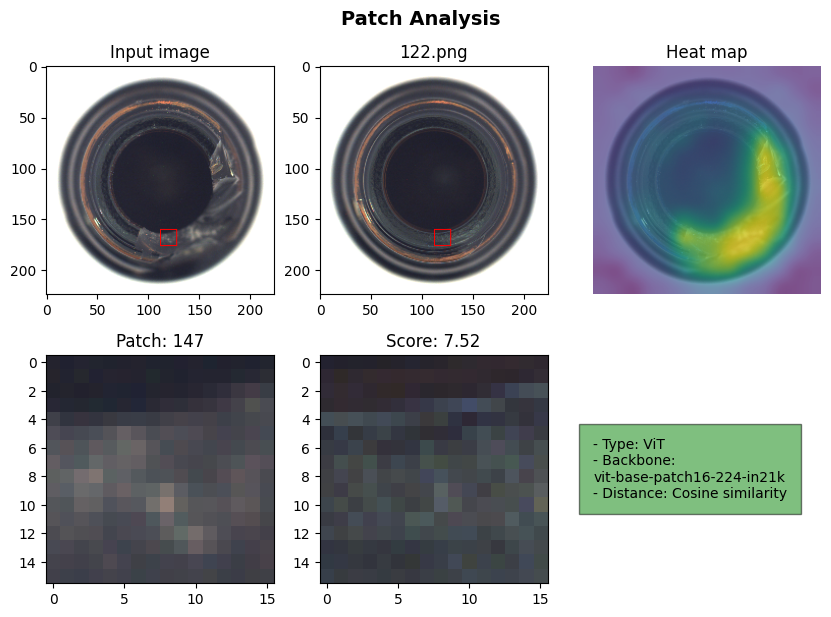

In [31]:
# Euclidean Distance
score, segm_map = pcViT.predict(sample_vit, euclidean_distance)

Utility.show(**show_config_vit)
# Utility.create_gif(filepath, pcViT, euclidean_distance, duration=150)

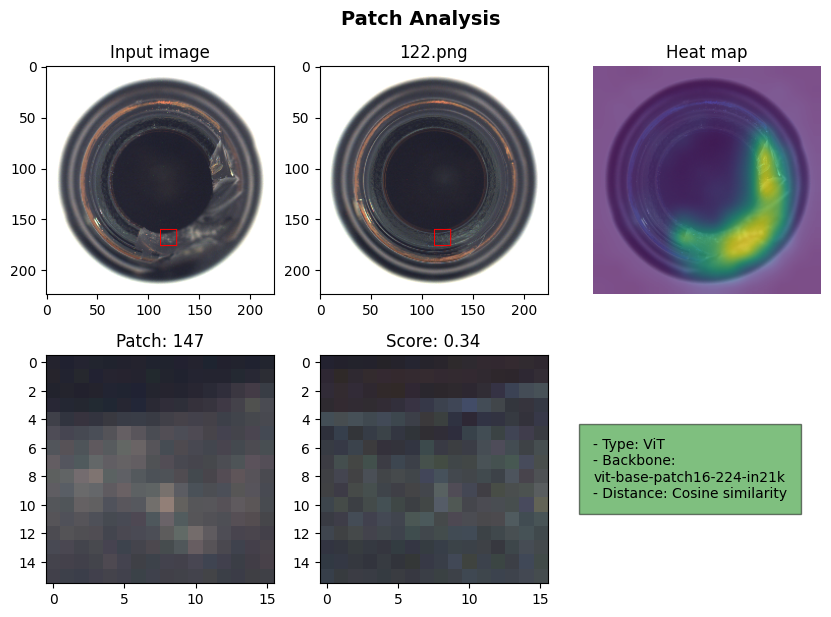

In [57]:
# Cosine Similarity Distance
score, segm_map = pcViT.predict(sample_vit, cosine_similarity_distance)

show_config_vit['distance_label'] = "Cosine similarity"
Utility.show(**show_config_vit)
# Utility.create_gif(filepath, pcViT, cosine_similarity_distance, duration=150)

## SWin

In [48]:
# Config
model_params_swin = {
  "layers" : [2],
  "blocks": [0, 1, 2, 3],
  "backbone" : "microsoft/swin-small-patch4-window7-224",
  "f_coreset" : 1
}

# Training ViT
pcSWin = PatchCoreSWin(**model_params_swin)
pcSWin.fit(["/content/bottle/bottle/train/good"])

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/199M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


[INFO][__init__] Model PatchCore loaded on device: cuda


  0%|          | 0/209 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/199M [00:00<?, ?B/s]

100%|██████████| 209/209 [00:15<00:00, 13.58it/s]


In [49]:
# Predict one sample
filepath = "/content/bottle/bottle/test/broken_large/000.png"
show_config_swin = {
    "input_idx": 147,
    "input_path": filepath,
    "model": pcSWin,
    "save": False,
    "alpha": 0.7
}

sample_swin = pcSWin.get_sample(filepath)

euclidean_distance = pcSWin.cdist
cosine_similarity_distance = pcSWin.sdist

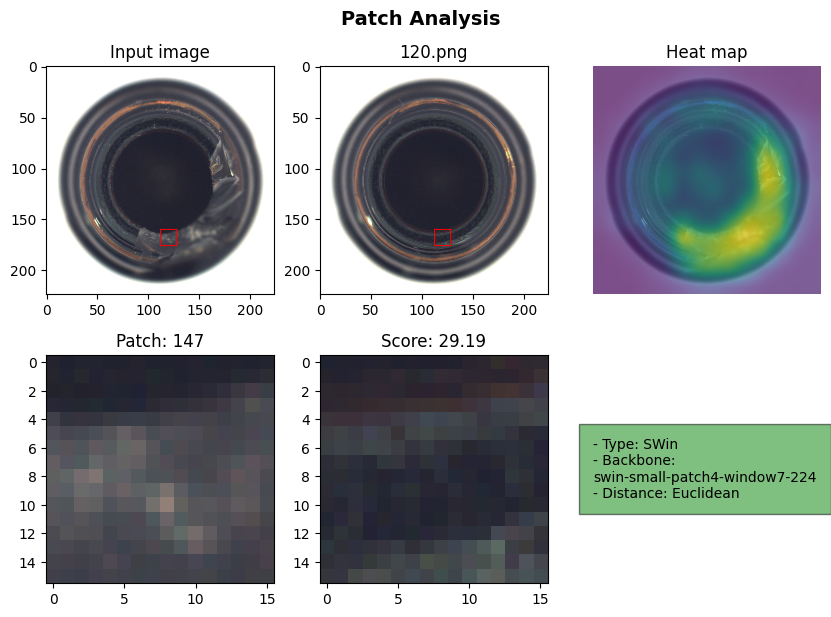

In [52]:
# Euclidean Distance
score, segm_map = pcSWin.predict(sample_swin, euclidean_distance)

Utility.show(**show_config_swin)
# Utility.create_gif(filepath, pcSWin, euclidean_distance, duration=150)

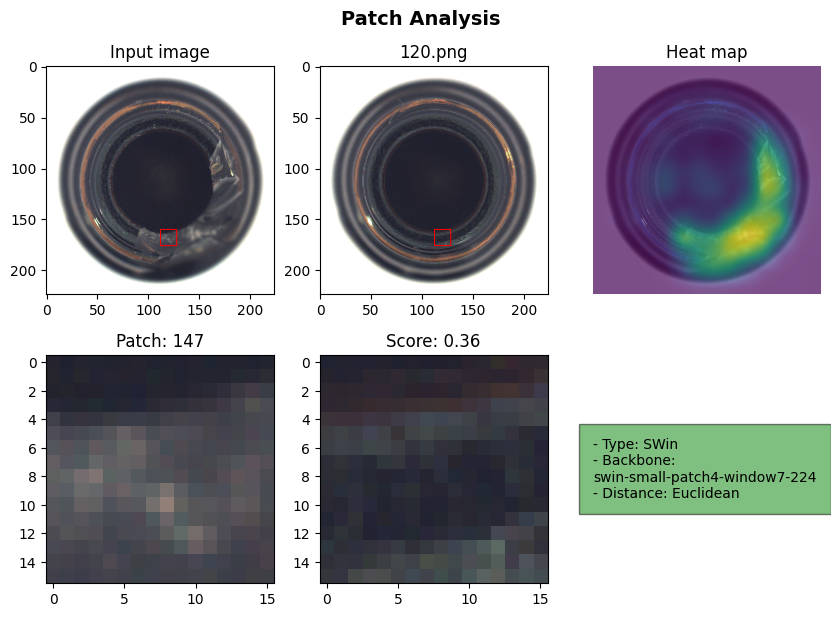

In [54]:
# Cosine Similarity Distance
score, segm_map = pcSWin.predict(sample_swin, cosine_similarity_distance)

show_config_vit['distance_label'] = "Cosine similarity"
Utility.show(**show_config_swin)
# Utility.create_gif(filepath, pcSWin, cosine_similarity_distance, duration=150)

# Prints

In [ ]:
importlib.reload(Utility)
importlib.reload(Thesis_dev)

from Utility import get_results, print_results, save_json
from Thesis_dev import MVTecDataset, PatchCoreViT, VanillaPatchCore, PatchCoreSWin

## Distance Comparison

In [58]:
# Config
model_params_vit = {
  "layers" : [4],
  "backbone" : "google/vit-base-patch16-224-in21k",
  "f_coreset" : 1
}

# Training ViT
pcViT = PatchCoreViT(**model_params_vit)
pcViT.fit(["/content/bottle/bottle/train/good"])

sample_vit = pcViT.get_sample(filepath)

euclidean_distance = pcViT.cdist
cosine_similarity_distance = pcViT.sdist

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


[INFO][__init__] Model PatchCore loaded on device: cuda


100%|██████████| 209/209 [00:11<00:00, 18.32it/s]


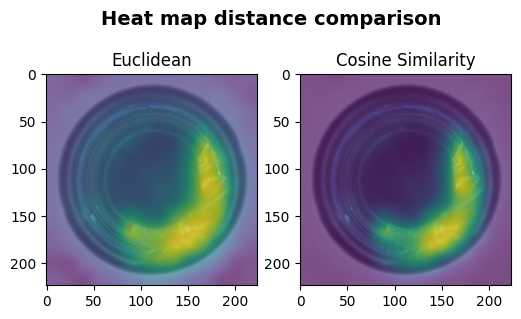

In [60]:
_, segm_map_euc = pcViT.predict(sample_vit, euclidean_distance)
_, segm_map_cos = pcViT.predict(sample_vit, cosine_similarity_distance)
_, _, input_resized = Utility.get_plot_images(0, filepath)

fig, axs = plt.subplots(1, 2, figsize=(6, 3.5))
fig.suptitle('Heat map distance comparison', fontsize=14, fontweight='bold')

axs[0].set_title('Euclidean')
axs[0].imshow(input_resized)
axs[0].imshow(segm_map_euc.reshape((224, 224)), alpha=0.7)

axs[1].set_title('Cosine Similarity')
axs[1].imshow(input_resized)
axs[1].imshow(segm_map_cos.reshape((224, 224)), alpha=0.7)

plt.savefig(f'heatmap_comparison.png')
# plt.close()
plt.show()

## CNN Gif